*If you have not already read it, you may want to start with the first tutorial: [Getting started with The Joker](1-Getting-started.ipynb). This is the first tutorial to use pymc3 and exoplanet: We do not explain how to use these packages here, but you may be interested in [this pymc3 tutorial](https://github.com/dfm/pymc3-tutorial) and the tutorials in the [exoplanet documentation](https://exoplanet.dfm.io/)* 

# Customizing the prior pdf in The Joker

As mentioned in the previous tutorial, the prior *pdf* used to generate prior samples in *The Joker* is customizable. For the nonlinear parameters (see previous tutorial for definition), the priors can be arbitrary probability distributions. For the linear parameters, the priors must be Gaussian, but the parameters are customizable. In the tutorial below, we will work through a few examples related to customizing the prior.

First, some imports we will need later:

In [1]:
import astropy.table as at
from astropy.time import Time
import astropy.units as u
from astropy.visualization.units import quantity_support
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pymc3 as pm
import exoplanet.units as xu

import thejoker as tj

In [2]:
# set up a random state to ensure reproducibility
rnd = np.random.RandomState(seed=42)

## Changing one or a few priors from the default prior

If you are mostly happy with the default prior used in *The Joker*, but want to replace the prior *pdf* for one or a few parameters, you can still use the ``JokerPrior.default()`` alternate initializer. To do this, you will need to first define parameter prior distributions as ``pymc3`` variables, then pass these variables in to ``.default()`` using the ``pars=...`` keyword argument. For example, imagine we had independent constraints on the period of a particular system and therefore wanted to impose a Gaussian prior on the period. As an example, let's assume that the mean and standard deviation of this Gaussian are 50 days and 1 day, respectively. To define this distribution, we will use the ``pymc3.Normal()`` class. As a final step, *The Joker* requires specifying the physical units of the parameters that we define using the [exoplanet.units](https://exoplanet.dfm.io/en/stable/user/api/#units) functionality:

In [3]:
with pm.Model() as model:
    P = xu.with_unit(pm.Normal('P', 50., 1),
                     u.day)
    
    prior = tj.JokerPrior.default(
        sigma_K0=30*u.km/u.s,
        sigma_v=100*u.km/u.s,
        pars={'P': P})
    
samples1 = prior.sample(size=100_000, random_state=rnd)

Let's now plot the period samples to make sure they look Gaussian:

Text(0.5, 0, '$P$ [day]')

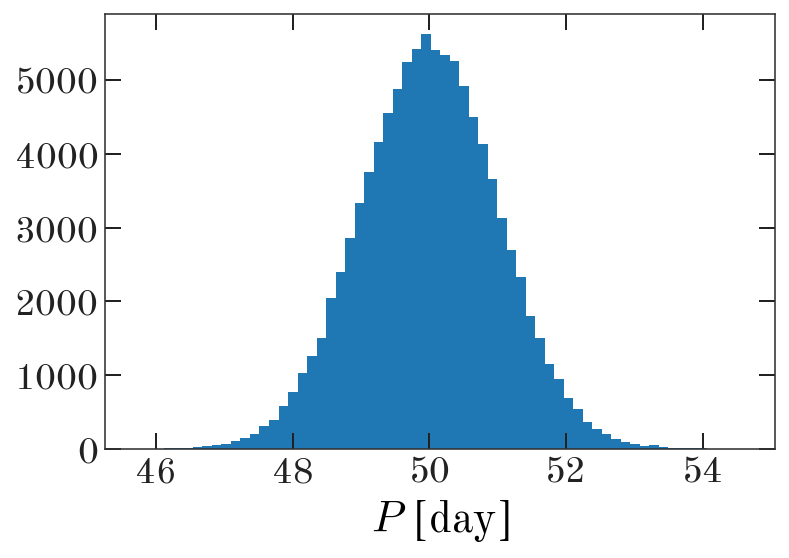

In [4]:
plt.hist(samples1['P'].to_value(u.day), bins=64);
plt.xlabel('$P$ [day]')

Indeed, it looks like the samples were generated by a Gaussian centered on 50 days, as we specified.

This type of replacement works for other parameters as well. For example, you may want to use a simpler prior on the velocity semi-amplitude, $K$, if you use a more restrictive prior on $P$. Here, remember that the prior on any linear parameter (including $K$) must be Gaussian, but we can customize the parameters of the Gaussian:

In [5]:
with pm.Model() as model:
    P = xu.with_unit(pm.Normal('P', 50., 1),
                     u.day)
    K = xu.with_unit(pm.Normal('K', 0., 15),
                     u.km/u.s)
    
    prior = tj.JokerPrior.default(
        sigma_v=100*u.km/u.s,
        pars={'P': P, 'K': K})
    
samples2 = prior.sample(size=100_000, random_state=rnd)
samples2

<JokerSamples [P, e, omega, M0, s] (100000 samples)>

By default, ``prior.sample()`` only generates the nonlinear parameters, so you will notice that ``K`` does not appear in the returned samples above (variable: ``samples2``). However, we can tell ``.sample()`` to also generate the linear parameters:

In [6]:
samples3 = prior.sample(size=100_000, generate_linear=True, 
                        random_state=rnd)
samples3

<JokerSamples [P, e, omega, M0, s, K, v0] (100000 samples)>

Note that now the ``samples3`` object contains ``K`` and ``v0``, the two linear parameters of the default version of *The Joker*. Next, we will generate full parameter samples (nonliner and linear parameters) for two different priors and compare orbits computed from these samples.

## Generating prior samples in both nonlinear and linear parameters

As mentioned in the previous example, ``prior.sample()`` can be told to generate samples in the linear parameters by passing in the argument ``generate_linear=True``. Let's construct samples from the default prior, and compare these samples to others generated from a customize prior that has a fixed ``K`` Gaussian (i.e. one that does not scale with period; see the previous tutorial or the documentation for ``JokerPrior.default()``):

In [7]:
default_prior = tj.JokerPrior.default(
    P_min=1e1*u.day,
    P_max=1e3*u.day,
    sigma_K0=30*u.km/u.s,
    sigma_v=75*u.km/u.s)
default_samples = default_prior.sample(size=20, generate_linear=True,
                                       random_state=rnd,
                                       t0=Time('J2000'))  # set arbitrary time zero-point

In [8]:
with pm.Model() as model:
    K = xu.with_unit(pm.Normal('K', 0., 30),
                     u.km/u.s)
    custom_prior = tj.JokerPrior.default(
        P_min=1e1*u.day,                              
        P_max=1e3*u.day,                              
        sigma_v=75*u.km/u.s,
        pars={'K': K})
    
custom_samples = custom_prior.sample(size=len(default_samples), 
                                     generate_linear=True, 
                                     random_state=rnd,
                                     t0=Time('J2000'))  # set arbitrary time zero-point

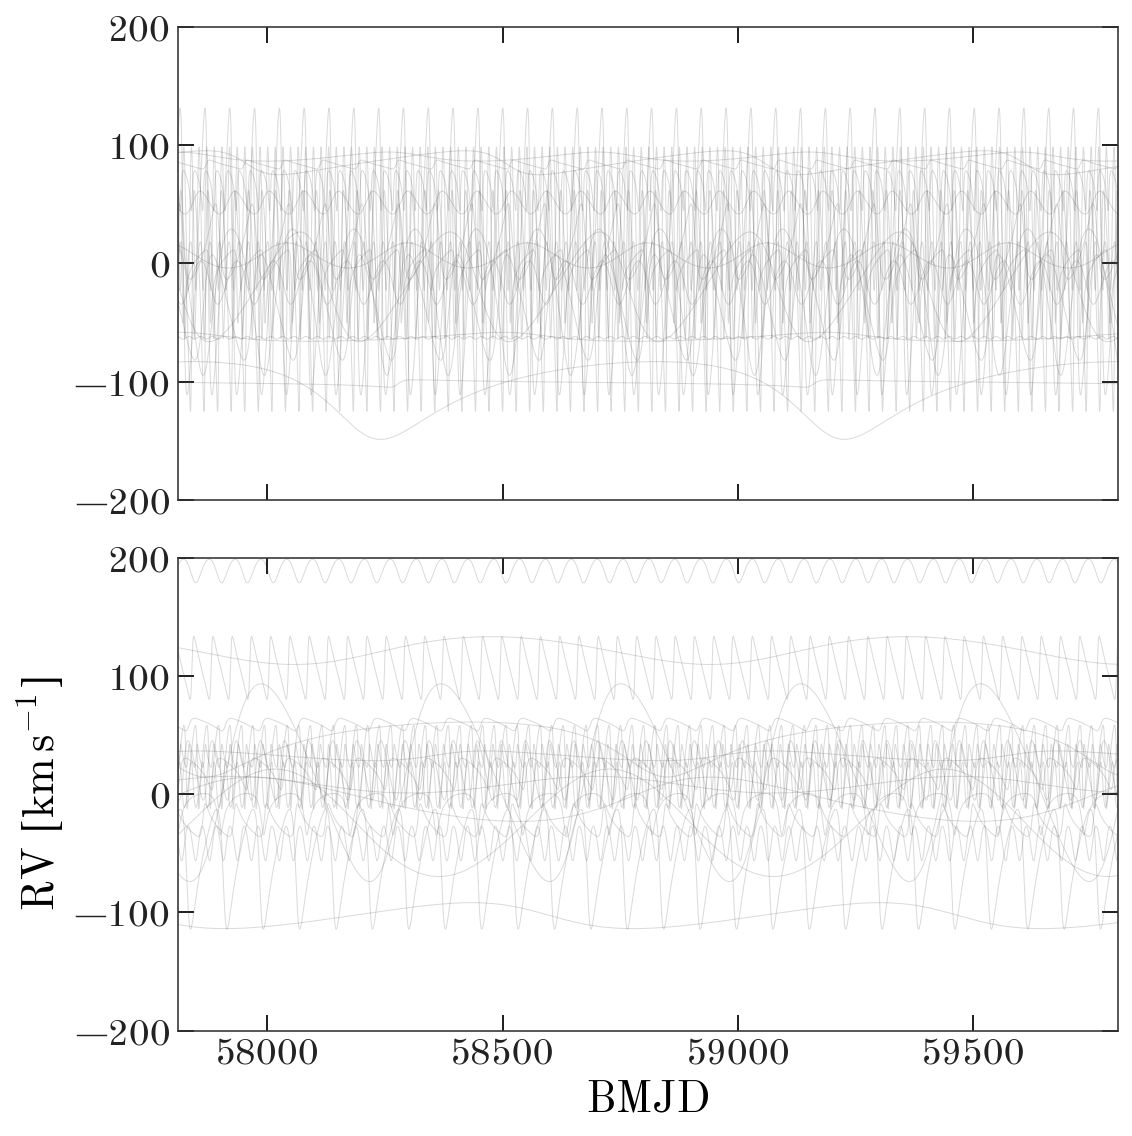

In [9]:
now_mjd = Time.now().mjd
t_grid = Time(np.linspace(now_mjd - 1000, now_mjd + 1000, 16384), 
              format='mjd')

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 8))
_ = tj.plot_rv_curves(default_samples, t_grid=t_grid, 
                      ax=axes[0], add_labels=False)
_ = tj.plot_rv_curves(custom_samples, t_grid=t_grid, 
                      ax=axes[1])
axes[0].set_ylim(-200, 200)
fig.tight_layout()